In [1]:
# !pip install boto3
from PIL import Image
import numpy as np
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


from PIL import Image
from transparent_background import Remover

In [2]:
import boto3
from PIL import Image
import requests
from io import BytesIO
from PIL import Image, ImageDraw


aws_access_key_id=''
aws_secret_access_key=''
aws_session_token=''

In [3]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
ls 'samples/test_set'

1.png   11.png  13.png  15.png  2.png   4.png   6.png   8.png
10.png  12.png  14.png  16.png  3.png   5.png   7.png   9.png


In [5]:
base_path = 'samples/test_set/'

In [7]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, m*1.0)))#m*0.5
            
        img2=np.dstack((img, m*1.0)) ### mask image
        return img2 ### get mask image

In [6]:
client = boto3.client(
  'textract',
  aws_access_key_id=aws_access_key_id,
  aws_secret_access_key=aws_secret_access_key,
  aws_session_token=aws_session_token,
  region_name='ap-south-1'
)

In [7]:
def read_file_as_byte(image_path):
  web_markers = ['.com', 'https', '.net']
  if any(web_marker in image_path for web_marker in web_markers):
    response = requests.get(image_path)
    image_bytes = response.content

    return image_bytes
  
  else:
    with open(image_path, 'rb') as img:
      image_bytes = img.read()

    return image_bytes

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [11]:
ls samples/test_set/

1.png   11.png  13.png  15.png  2.png   4.png   6.png   8.png
10.png  12.png  14.png  16.png  3.png   5.png   7.png   9.png


In [12]:
base_path = 'samples/test_set/'

In [13]:
image_path = base_path + '1.png'
background_path = 'samples/backgrounds/b2.jpg'

In [19]:
def text_mask(image_path):
    image = Image.open(image_path)
    image_bytes = read_file_as_byte(image_path)

    response = client.detect_document_text(
            Document={ "Bytes": image_bytes })

    blocks=response['Blocks']
    width, height =image.size   

    input_boxes = []
    for block in blocks:
        if block['BlockType'] == "WORD":
            input_boxes.append([
                width * block['Geometry']['Polygon'][0]['X'],
                height * block['Geometry']['Polygon'][1]['Y'],
                width * block['Geometry']['Polygon'][2]['X'],
                height * block['Geometry']['Polygon'][3]['Y']
             ])

    input_boxes = torch.tensor(input_boxes, device=predictor.device)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictor.set_image(image)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )


    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    list_of_masks = [mask for mask in masks]
    combined_masks = np.max(list_of_masks, axis=0).reshape(image.shape[0],image.shape[1],1)
    masked_image = image * combined_masks

    # Display the original image
    axs[0].imshow(image)
    axs[0].set_title('Original Image ')
    axs[0].axis('off')

    # Display the Masked image
    axs[1].imshow(masked_image)
    axs[1].set_title('Text Mask')
    axs[1].axis('off')

    plt.show()

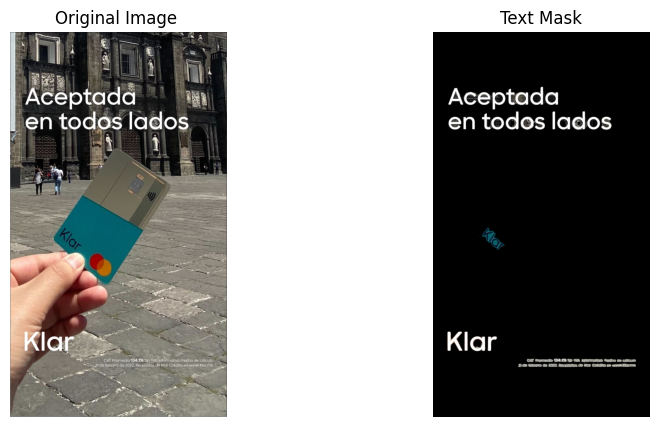

In [21]:
text_mask(base_path + '1.png')

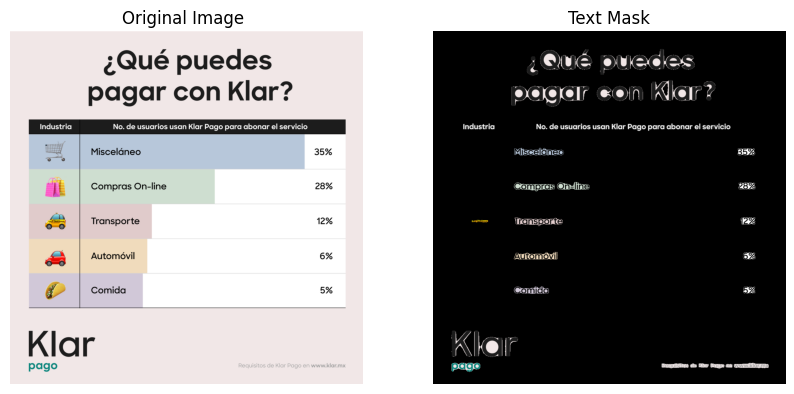

In [20]:
text_mask(base_path + '2.png')

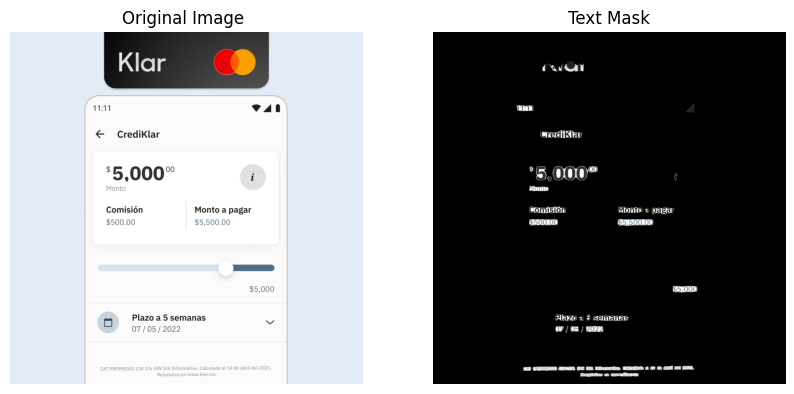

In [23]:
text_mask(base_path + '3.png')